# Análise do Artigo

Este notebook documenta a análise e reprodução de um estudo sobre a aplicação de algoritmos de Machine Learning para prever doenças cardíacas isquêmicas, utilizando um dataset disponível no Kaggle:

https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset?resource=download

Nosso objetivo é replicar e expandir os passos descritos no estudo, desde a leitura e pré-processamento dos dados até a implementação e avaliação de diferentes modelos de classificação. Ao longo deste trabalho, investigaremos as inconsistências encontradas entre o dataset utilizado e as informações reportadas no artigo original, e compararemos o desempenho de algoritmos como KNN, Random Forest, Regressão Logística, SVC, Gaussian Naïve Bayes e Decision Trees, avaliando suas métricas de acurácia, precisão, recall, F1-score, especificidade e AUC.

Além disso, trataremos também do deep learning, algoritmo não implementado durante o estudo, mas que foi mencionado como "próximos passos". Assim, iremos um pocuo além do artigo, enriquecendo a análise original com mais outro método.

As seções a seguir detalham cada etapa do processo, apresentando o código utilizado, os resultados obtidos e discussões sobre as observações relevantes, incluindo as diferenças encontradas em relação ao estudo base.

## Inicialização do Drive para e imports

In [ ]:
from google.colab import drive
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

drive.mount('/content/drive')

Mounted at /content/drive


##Leitura do CSV com Pandas

In [ ]:
file_path = '/content/drive/My Drive/heart.csv'
df = pd.read_csv(file_path)

# Pré-processamento de Dados

Nesse momento, exploraremos a natureza dos dados analisados para efeitos da melhor possível análise.

### Dataset inicial

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


#### **Inconsistência** descoberta: duplicatas

Durante o pré-processamento de dados, descobrimos inconsistêncais relacionadas ao estudo publicado. Durante nossa análise, como demonstrado abaixo, encontramos 723 duplicatas no dataset do kaggle. Isso é inconsistente com o estudo publicado, que informou não haver dataset no pré-processamento de dados. Isso é uma limitação, já que vamos remover as duplicatas e trabalhar com o restante dos dados. Isso faz com que não consigamos reproduzir com precisão os passos executados no estudo.

In [ ]:
# Verificação inicial de duplicatas
print(f"Formato inicial do dataset: {df.shape}")
num_duplicatas = df.duplicated().sum()
print(f"Número de duplicatas no dataset: {num_duplicatas}")

Formato inicial do dataset: (1025, 14)
Número de duplicatas no dataset: 723


### Seleção e renomeação de colunas pertinentes para o estudo

Aqui, descartamos as colunas indesejáveis 'ca' e 'thal', que não foram citadas no estudo.

In [ ]:
# Selecionar as 11 features e o target especificados
features_selecionadas = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope']
target = 'target'
colunas_para_manter = features_selecionadas + [target]

# Descartar colunas não necessárias
colunas_para_descartar = [col for col in df.columns if col not in colunas_para_manter]
if colunas_para_descartar:
    df = df.drop(columns=colunas_para_descartar)
    print(f"Colunas descartadas: {colunas_para_descartar}")

print(f"Formato do dataset após seleção de colunas: {df.shape}")


Colunas descartadas: ['ca', 'thal']
Formato do dataset após seleção de colunas: (1025, 12)


In [ ]:
renomear_colunas = {
    'age': 'Age',
    'sex': 'Sex',
    'cp': 'ChestPainType',
    'trestbps': 'RestingBP',
    'chol': 'Cholesterol',
    'fbs': 'FastingBS',
    'restecg': 'RestingECG',
    'thalach': 'MaxHR',
    'exang': 'ExerciseAngina',
    'oldpeak': 'Oldpeak',
    'slope': 'ST_Slope',
    'target': 'HeartDisease'
}
df = df.rename(columns=renomear_colunas)
print("\nColunas após renomeação:")
print(df.columns.tolist())


Colunas após renomeação:
['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,52,1,0,125,212,0,1,168,0,1.0,2,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0
3,61,1,0,148,203,0,1,161,0,0.0,2,0
4,62,0,0,138,294,1,1,106,0,1.9,1,0


### Limpeza dos Dados

In [ ]:
print(f"Número de instâncias antes do tratamento de outliers: {len(df)}")

Número de instâncias antes do tratamento de outliers: 1025


### Tratamento de Outliers

#### **Inconsistência** descoberta

No estudo é mencionado que 170 instâncias de colesterol possuem valor 0. Aqui, nenhuma instância de colesterol foi encontrada com o valor 0.

Além disso, no estudo é informado que 8 outliers do colesterol foram encontrados ao removerem valores acima de 450 e menores que 100. Aqui, foram encontrados apenas 3, todos acima de 450.

In [ ]:
# 1. Tratar valores de Colesterol = 0
# "Tratar especificamente os 170 casos onde o valor do colesterol é 0, substituindo-os pela mediana da feature Colesterol"
chol_zero_count = df[df['Cholesterol'] == 0].shape[0]
print(f"\nNúmero de instâncias com Colesterol == 0: {chol_zero_count}")

if chol_zero_count > 0:
    median_chol = df[df['Cholesterol'] != 0]['Cholesterol'].median()
    df['Cholesterol'] = df['Cholesterol'].replace(0, median_chol)
    print(f"Valores de Colesterol == 0 substituídos pela mediana ({median_chol}).")
    print(f"Número de instâncias com Colesterol == 0 após substituição: {df[df['Cholesterol'] == 0].shape[0]}")

# 2. Remover outliers de colesterol: maiores que 450 OU menores que 100
print(f"\nTratando outliers de Colesterol (valores > 450 ou < 100)...")

if not df.empty:
    # Calcular a média do colesterol ANTES de remover os outliers
    mean_cholesterol_before_removal = df['Cholesterol'].mean()
    print(f"Média do Colesterol (antes da remoção dos outliers): {mean_cholesterol_before_removal:.2f}")

    # Identificar os outliers
    outliers_condition = (df['Cholesterol'] > 450) | (df['Cholesterol'] < 100)
    outlier_instances = df[outliers_condition]
    num_outliers = len(outlier_instances)

    if num_outliers > 0:
        outliers_chol_values = outlier_instances['Cholesterol'].tolist()
        outliers_chol_indices = outlier_instances.index

        print(f"Número de outliers de Colesterol a serem removidos (> 450 ou < 100): {num_outliers}")
        print(f"Valores de Colesterol a serem removidos: {sorted(outliers_chol_values)}")

        # Remover as instâncias
        df = df.drop(outliers_chol_indices)
        print(f"Removidas {num_outliers} instâncias com Colesterol > 450 ou < 100.")
        print(f"Número de instâncias após remoção de outliers de Colesterol: {len(df)}")

        if not df.empty:
             mean_cholesterol_after_removal = df['Cholesterol'].mean()
             print(f"Média do Colesterol (após a remoção dos outliers): {mean_cholesterol_after_removal:.2f}")
        else:
            print("DataFrame ficou vazio após a remoção dos outliers.")

    else:
        print("Não foram encontrados outliers de Colesterol com valores > 450 ou < 100.")
        print(f"Número de instâncias (sem alteração por outliers): {len(df)}")
else:
    print("\nDataFrame está vazio. Não é possível processar outliers de Colesterol.")


Número de instâncias com Colesterol == 0: 0

Tratando outliers de Colesterol (valores > 450 ou < 100)...
Média do Colesterol (antes da remoção dos outliers): 246.00
Número de outliers de Colesterol a serem removidos (> 450 ou < 100): 3
Valores de Colesterol a serem removidos: [564, 564, 564]
Removidas 3 instâncias com Colesterol > 450 ou < 100.
Número de instâncias após remoção de outliers de Colesterol: 1022
Média do Colesterol (após a remoção dos outliers): 245.07


#### Tratamento dos Outliers de RestingBP e Oldpeak

O estudo não descreve como os outliers de RestingBP e Oldpeak foram tratados, então utilizamos o método IQR.

In [ ]:
features_com_outliers = ['RestingBP', 'Oldpeak']
for feature in features_com_outliers:
    if feature in df.columns:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_antes = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].shape[0]
        if outliers_antes > 0:
            df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
            print(f"\nRemovidos {outliers_antes} outliers da feature '{feature}' usando o método IQR.")
            print(f"Número de instâncias após tratamento de outliers em '{feature}': {len(df)}")
        else:
            print(f"\nNenhum outlier detectado para remoção na feature '{feature}' usando o método IQR.")
    else:
        print(f"\nAviso: A coluna '{feature}' não foi encontrada para tratamento de outliers.")


print(f"\nFormato final do dataset após tratamento de outliers: {df.shape}")


Removidos 30 outliers da feature 'RestingBP' usando o método IQR.
Número de instâncias após tratamento de outliers em 'RestingBP': 992

Removidos 7 outliers da feature 'Oldpeak' usando o método IQR.
Número de instâncias após tratamento de outliers em 'Oldpeak': 985

Formato final do dataset após tratamento de outliers: (985, 12)


#### Tratamento de valores nulos e duplicados

In [ ]:
print(f"\nValores nulos por coluna após limpeza:\n{df.isnull().sum()}")
print(f"Número de linhas duplicadas após limpeza: {df.duplicated().sum()}")

if df.duplicated().sum() > 0:
    df = df.drop_duplicates(keep='first')
    print(f"Linhas duplicadas removidas. Novo formato: {df.shape}")


Valores nulos por coluna após limpeza:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Número de linhas duplicadas após limpeza: 695
Linhas duplicadas removidas. Novo formato: (290, 12)


### Data Encoding

In [ ]:
# Separar features (X) e target (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Features categóricas a serem codificadas usando LabelEncoder
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

label_encoders = {}
print("\nCodificando features categóricas com LabelEncoder:")
for col in categorical_features:
    if col in X.columns: # Verificar se a coluna existe
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le # Guardar para referência, se necessário
        print(f"Feature '{col}' codificada.")
    else:
        print(f"Aviso: Coluna categórica '{col}' não encontrada em X para codificação.")


Codificando features categóricas com LabelEncoder:
Feature 'Sex' codificada.
Feature 'ChestPainType' codificada.
Feature 'RestingECG' codificada.
Feature 'ExerciseAngina' codificada.
Feature 'ST_Slope' codificada.


In [ ]:
df.head(100)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,52,1,0,125,212,0,1,168,0,1.0,2,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0
3,61,1,0,148,203,0,1,161,0,0.0,2,0
4,62,0,0,138,294,1,1,106,0,1.9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
116,63,1,0,130,254,0,0,147,0,1.4,1,0
117,43,1,0,120,177,0,0,120,1,2.5,1,0
119,42,1,1,120,295,0,1,162,0,0.0,2,1
122,60,1,0,145,282,0,0,142,1,2.8,1,0


### Divisão do Conjunto de Dados e Escalonamento

In [ ]:
# Dividir os dados em conjuntos de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

print(f"\nFormato de X_train: {X_train.shape}, Formato de X_test: {X_test.shape}")
print(f"Formato de y_train: {y_train.shape}, Formato de y_test: {y_test.shape}")

# Escalonamento de Dados (Data Scaling) com StandardScaler
scaler = StandardScaler()

# Ajustar o scaler APENAS nos dados de treinamento
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar o scaler treinado aos dados de teste
X_test_scaled = scaler.transform(X_test)

# Converter de volta para DataFrame para visualização (opcional)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nPrimeiras 5 linhas de X_train_scaled:")
print(X_train_scaled_df.head())


Formato de X_train: (203, 11), Formato de X_test: (87, 11)
Formato de y_train: (203,), Formato de y_test: (87,)

Primeiras 5 linhas de X_train_scaled:
        Age       Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0 -1.126682  0.632456       1.006380   0.000695    -0.302448  -0.416426   
1  1.010855 -1.581139      -0.920932  -1.550971     0.416580  -0.416426   
2  0.448345  0.632456      -0.920932  -0.351956     1.035743  -0.416426   
3  1.798368  0.632456      -0.920932   0.000695     1.475149  -0.416426   
4  0.898353  0.632456       1.006380   0.000695    -0.342394  -0.416426   

   RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  
0    0.913537  1.224764        1.457078 -0.580602  0.985329  
1    0.913537  0.795727        1.457078  0.690639 -0.681519  
2   -0.978790  0.881534       -0.686305 -0.943814  0.985329  
3   -0.978790 -1.778497       -0.686305  1.235457 -0.681519  
4    0.913537 -0.191059       -0.686305  0.690639 -0.681519  


#KNN - Treinamento e avaliação (antes do Tunning)

Antes de otimizar os hiperparâmetros do KNN, treinamos o modelo com sua configuração padrão. Esta etapa é imprescindível para entender o desempenho inicial do algoritmo e ter uma base sólida para avaliar o impacto do tuning subsequente. As métricas de avaliação calculadas aqui representam o desempenho do KNN "out-of-the-box".

In [ ]:
# Instanciar o KNeighborsClassifier com K=5 (um valor comum inicial, ou default do sklearn)
knn_initial = KNeighborsClassifier(n_neighbors=5)

# Treinar o modelo usando o conjunto de treinamento escalonado
print("\nTreinando o modelo KNN inicial (K=5)...")
knn_initial.fit(X_train_scaled, y_train)
print("Modelo KNN inicial treinado.")


Treinando o modelo KNN inicial (K=5)...
Modelo KNN inicial treinado.


### Avaliação do Modelo


Avaliando o modelo KNN inicial...

Métricas do Modelo KNN Inicial (Antes do Tuning):
  Acurácia: 0.7586
  Precisão: 0.7547
  Recall (Sensibilidade): 0.8333
  F1 Score: 0.7921
  Especificidade: 0.6667
  AUC: 0.8130

Matriz de Confusão (Modelo Inicial):
  Verdadeiros Positivos (TP): 40
  Falsos Positivos (FP): 13
  Verdadeiros Negativos (TN): 26
  Falsos Negativos (FN): 8


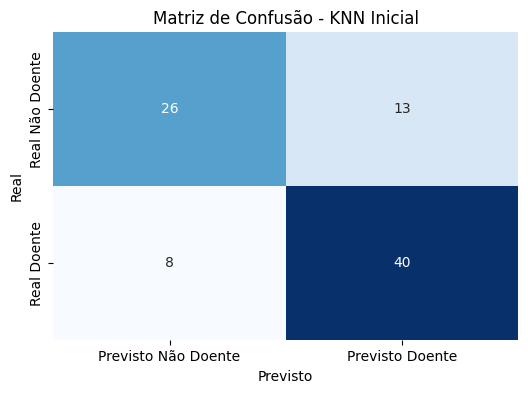

In [ ]:
# Célula 8: Avaliação do Modelo KNN (Antes do Tuning)

print("\nAvaliando o modelo KNN inicial...")
# Fazer previsões no conjunto de teste escalonado
y_pred_initial = knn_initial.predict(X_test_scaled)
y_pred_proba_initial = knn_initial.predict_proba(X_test_scaled)[:, 1] # Probabilidades para AUC

# Calcular métricas de avaliação
accuracy_initial = accuracy_score(y_test, y_pred_initial)
precision_initial = precision_score(y_test, y_pred_initial)
recall_initial = recall_score(y_test, y_pred_initial)
f1_initial = f1_score(y_test, y_pred_initial)
auc_initial = roc_auc_score(y_test, y_pred_proba_initial)

# Calcular Matriz de Confusão e Especificidade
cm_initial = confusion_matrix(y_test, y_pred_initial)
tn_initial, fp_initial, fn_initial, tp_initial = cm_initial.ravel()
specificity_initial = tn_initial / (tn_initial + fp_initial)

print("\nMétricas do Modelo KNN Inicial (Antes do Tuning):")
print(f"  Acurácia: {accuracy_initial:.4f}")
print(f"  Precisão: {precision_initial:.4f}")
print(f"  Recall (Sensibilidade): {recall_initial:.4f}")
print(f"  F1 Score: {f1_initial:.4f}")
print(f"  Especificidade: {specificity_initial:.4f}")
print(f"  AUC: {auc_initial:.4f}")

print("\nMatriz de Confusão (Modelo Inicial):")
print(f"  Verdadeiros Positivos (TP): {tp_initial}")
print(f"  Falsos Positivos (FP): {fp_initial}")
print(f"  Verdadeiros Negativos (TN): {tn_initial}")
print(f"  Falsos Negativos (FN): {fn_initial}")

# Plotar Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_initial, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Previsto Não Doente', 'Previsto Doente'],
            yticklabels=['Real Não Doente', 'Real Doente'])
plt.title('Matriz de Confusão - KNN Inicial')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

# Guardar métricas para comparação posterior
metrics_initial = {
    'Acurácia': accuracy_initial,
    'Precisão': precision_initial,
    'Recall': recall_initial,
    'F1 Score': f1_initial,
    'Especificidade': specificity_initial,
    'AUC': auc_initial
}

#Ajuste de Hiperparâmetros para o KNN com o RandomizedSearchCV

Após avaliar o desempenho inicial do KNN com parâmetros padrão, buscamos aprimorá-lo através do ajuste de hiperparâmetros. Utilizamos o RandomizedSearchCV, que explora um espaço de parâmetros definido de forma aleatória e aplica validação cruzada para avaliar cada combinação, selecionando ao final a que obteve a melhor pontuação na métrica definida (neste caso, AUC ou Acurácia).

In [ ]:
# Célula 9: Ajuste de Hiperparâmetros para KNN (RandomizedSearchCV)

print("\nIniciando o ajuste de hiperparâmetros para KNN com RandomizedSearchCV...")

# Definir o espaço de busca para os hiperparâmetros do KNN
param_dist_knn = {
    'n_neighbors': list(range(1, 31)), # K de 1 a 30
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'], # Adicionando Minkowski
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': list(range(10, 51, 5)) # de 10 a 50, com passo 5
}

# Instanciar KNeighborsClassifier (sem parâmetros fixos aqui)
knn_for_tuning = KNeighborsClassifier()

# Configurar RandomizedSearchCV
# Usar validação cruzada (ex: 5-fold cross-validation)
# n_iter controla o número de combinações de parâmetros testadas
# Scoring: 'roc_auc' é uma boa métrica geral, ou 'accuracy'
random_search_knn = RandomizedSearchCV(
    estimator=knn_for_tuning,
    param_distributions=param_dist_knn,
    n_iter=100,  # Número de iterações (combinações de parâmetros)
    cv=5,        # Número de folds para cross-validation
    scoring='roc_auc', # Métrica para otimização
    random_state=RANDOM_STATE,
    n_jobs=-1,    # Usar todos os processadores disponíveis
    verbose=1     # Mostrar progresso
)

# Treinar o RandomizedSearchCV no conjunto de treinamento escalonado
random_search_knn.fit(X_train_scaled, y_train)

# Obter os melhores hiperparâmetros
best_params_knn = random_search_knn.best_params_
print("\nMelhores hiperparâmetros encontrados para KNN:")
print(best_params_knn)
print(f"Melhor pontuação ROC AUC (validação cruzada): {random_search_knn.best_score_:.4f}")


Iniciando o ajuste de hiperparâmetros para KNN com RandomizedSearchCV...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Melhores hiperparâmetros encontrados para KNN:
{'weights': 'distance', 'n_neighbors': 27, 'metric': 'manhattan', 'leaf_size': 30, 'algorithm': 'ball_tree'}
Melhor pontuação ROC AUC (validação cruzada): 0.8864


#KNN - Treinamento e avaliação (agora otimizado)

In [ ]:
# Célula 10: Treinamento do Modelo KNN Otimizado

print("\nTreinando o modelo KNN otimizado com os melhores hiperparâmetros...")

# Instanciar e treinar um novo modelo KNeighborsClassifier usando os melhores hiperparâmetros
knn_optimized = KNeighborsClassifier(**best_params_knn)
knn_optimized.fit(X_train_scaled, y_train)
print("Modelo KNN otimizado treinado.")


Treinando o modelo KNN otimizado com os melhores hiperparâmetros...
Modelo KNN otimizado treinado.



Avaliando o modelo KNN otimizado...

Métricas do Modelo KNN Otimizado (Após Tuning):
  Acurácia: 0.7816
  Precisão: 0.7636
  Recall (Sensibilidade): 0.8750
  F1 Score: 0.8155
  Especificidade: 0.6667
  AUC: 0.8595

Matriz de Confusão (Modelo Otimizado):
  Verdadeiros Positivos (TP): 42
  Falsos Positivos (FP): 13
  Verdadeiros Negativos (TN): 26
  Falsos Negativos (FN): 6


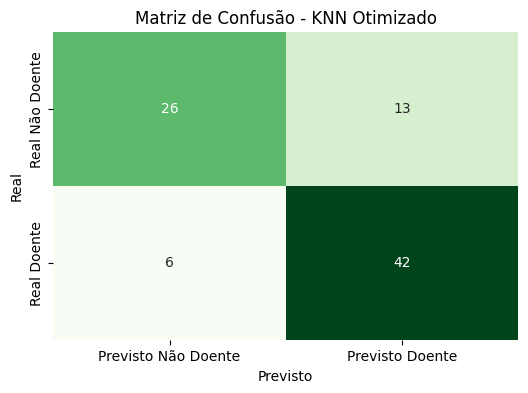

In [ ]:
# Célula 11: Avaliação do Modelo KNN Otimizado

print("\nAvaliando o modelo KNN otimizado...")
# Fazer previsões no conjunto de teste escalonado
y_pred_optimized = knn_optimized.predict(X_test_scaled)
y_pred_proba_optimized = knn_optimized.predict_proba(X_test_scaled)[:, 1] # Probabilidades para AUC

# Calcular métricas de avaliação
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

# Calcular Matriz de Confusão e Especificidade
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
tn_optimized, fp_optimized, fn_optimized, tp_optimized = cm_optimized.ravel()
specificity_optimized = tn_optimized / (tn_optimized + fp_optimized) if (tn_optimized + fp_optimized) > 0 else 0

print("\nMétricas do Modelo KNN Otimizado (Após Tuning):")
print(f"  Acurácia: {accuracy_optimized:.4f}")
print(f"  Precisão: {precision_optimized:.4f}")
print(f"  Recall (Sensibilidade): {recall_optimized:.4f}")
print(f"  F1 Score: {f1_optimized:.4f}")
print(f"  Especificidade: {specificity_optimized:.4f}")
print(f"  AUC: {auc_optimized:.4f}")

print("\nMatriz de Confusão (Modelo Otimizado):")
print(f"  Verdadeiros Positivos (TP): {tp_optimized}")
print(f"  Falsos Positivos (FP): {fp_optimized}")
print(f"  Verdadeiros Negativos (TN): {tn_optimized}")
print(f"  Falsos Negativos (FN): {fn_optimized}")

# Plotar Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Previsto Não Doente', 'Previsto Doente'],
            yticklabels=['Real Não Doente', 'Real Doente'])
plt.title('Matriz de Confusão - KNN Otimizado')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

# Guardar métricas para comparação
metrics_optimized = {
    'Acurácia': accuracy_optimized,
    'Precisão': precision_optimized,
    'Recall': recall_optimized,
    'F1 Score': f1_optimized,
    'Especificidade': specificity_optimized,
    'AUC': auc_optimized
}

# Comparação: KNN inicial vs KNN otimizado

O ajuste de hiperparâmetros tem o potencial de melhorar significativamente o desempenho de um modelo. Para quantificar o impacto da otimização realizada com o RandomizedSearchCV no nosso modelo KNN, dedicamos esta seção à comparação detalhada das métricas de avaliação. Analisaremos se o modelo otimizado obteve ganhos de performance em relação à versão inicial e discutiremos as implicações dessas melhorias para a capacidade preditiva do modelo.


Comparando métricas do KNN antes e depois do ajuste de hiperparâmetros...


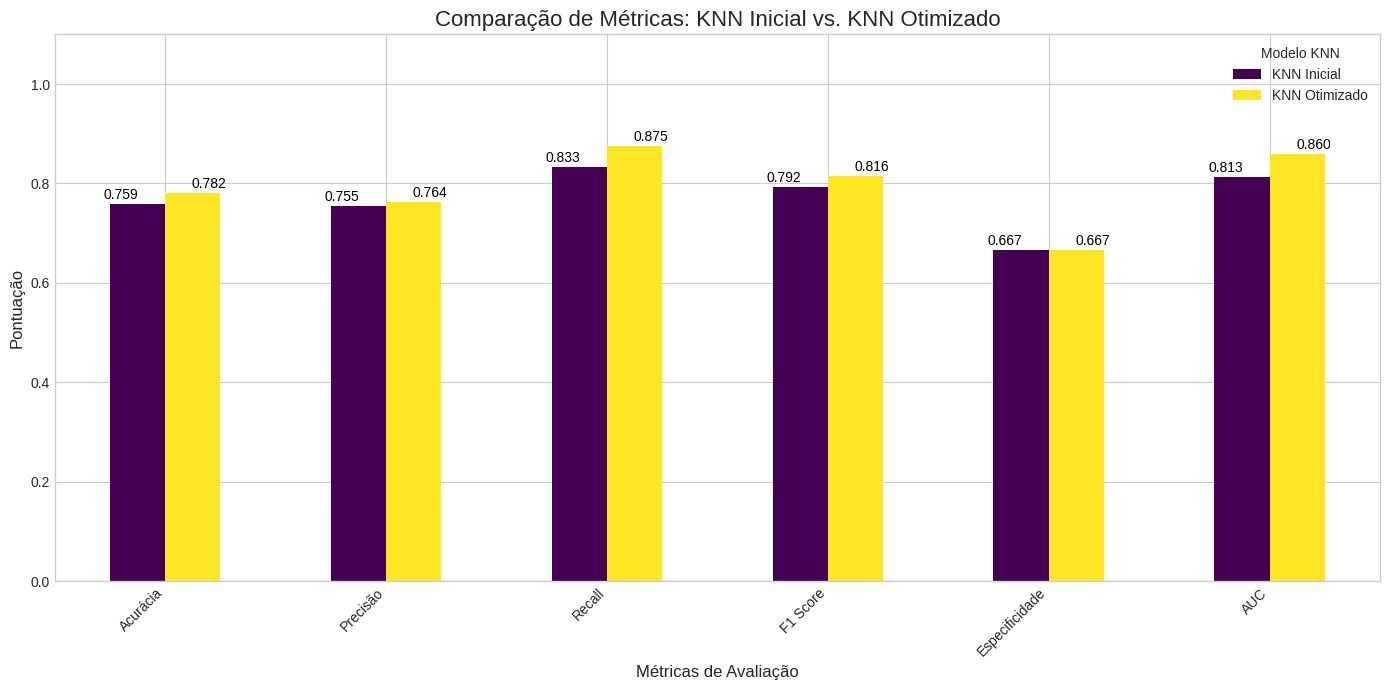


Resumo da Comparação:
          Métrica  KNN Inicial  KNN Otimizado
0        Acurácia     0.758621       0.781609
1        Precisão     0.754717       0.763636
2          Recall     0.833333       0.875000
3        F1 Score     0.792079       0.815534
4  Especificidade     0.666667       0.666667
5             AUC     0.813034       0.859509


In [ ]:
# Célula 12: Comparação Gráfica das Métricas de Avaliação

print("\nComparando métricas do KNN antes e depois do ajuste de hiperparâmetros...")

# Criar DataFrame para plotagem
metrics_names = list(metrics_initial.keys())
initial_scores = [metrics_initial[metric] for metric in metrics_names]
optimized_scores = [metrics_optimized[metric] for metric in metrics_names]

comparison_df = pd.DataFrame({
    'Métrica': metrics_names,
    'KNN Inicial': initial_scores,
    'KNN Otimizado': optimized_scores
})

# Plotar gráfico de barras comparativo
plt.style.use('seaborn-v0_8-whitegrid') # Usando um estilo do seaborn
comparison_df.set_index('Métrica').plot(kind='bar', figsize=(14, 7), colormap='viridis')
plt.title('Comparação de Métricas: KNN Inicial vs. KNN Otimizado', fontsize=16)
plt.ylabel('Pontuação', fontsize=12)
plt.xlabel('Métricas de Avaliação', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title='Modelo KNN')
plt.tight_layout() # Ajustar layout para evitar sobreposição
# Adicionar os valores nas barras
for i, (initial_val, optimized_val) in enumerate(zip(initial_scores, optimized_scores)):
    plt.text(i - 0.2, initial_val + 0.01, f"{initial_val:.3f}", color='black', ha='center')
    plt.text(i + 0.2, optimized_val + 0.01, f"{optimized_val:.3f}", color='black', ha='center')

plt.ylim(0, 1.1) # Definir limite do eixo y para melhor visualização das barras
plt.show()

print("\nResumo da Comparação:")
print(comparison_df)

#Random Forest - Treino e avaliação

Seguindo o algoritmo, o random forest é um algoritmo de Machine Learning baseado em árvores de decisão. Ele constrói múltiplas árvores durante o treinamento e produz a classe que é a moda das classes (classificação) ou a previsão média (regressão) das árvores individuais. Nesta seção, treinamos e avaliamos o modelo random forest nos nossos dados para verificar seu desempenho.

In [ ]:
# Célula 2: Treinamento do Modelo Random Forest (com parâmetros padrão)
print("Treinando o modelo Random Forest com parâmetros padrão...")

# Instanciar o RandomForestClassifier
# Utilizar random_state para garantir a reprodutibilidade dos resultados do modelo
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Treinar o modelo com os dados de treinamento (supostamente escalonados)
# Nota: Random Forest não é tão sensível à escala das features quanto algoritmos baseados em distância,
# mas usar os dados escalonados mantém a consistência com o pipeline anterior (ex: KNN).
rf_model.fit(X_train_scaled, y_train)

print("Modelo Random Forest treinado com sucesso.")

Treinando o modelo Random Forest com parâmetros padrão...
Modelo Random Forest treinado com sucesso.


In [ ]:
print("\nAvaliando o modelo Random Forest no conjunto de teste...")

# Fazer previsões no conjunto de teste
y_pred_rf = rf_model.predict(X_test_scaled)

# Obter probabilidades para o cálculo do AUC
# predict_proba retorna um array com probabilidades para cada classe (coluna 0 para classe 0, coluna 1 para classe 1)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# 1. Acurácia (Accuracy)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"  Acurácia (Accuracy): {accuracy_rf:.4f}")

# 2. Precisão (Precision)
precision_rf = precision_score(y_test, y_pred_rf)
print(f"  Precisão (Precision): {precision_rf:.4f}")

# 3. Recall (Sensibilidade)
recall_rf = recall_score(y_test, y_pred_rf)
print(f"  Recall (Sensibilidade): {recall_rf:.4f}")

# 4. F1 Score
f1_rf = f1_score(y_test, y_pred_rf)
print(f"  F1 Score: {f1_rf:.4f}")

# 5. Matriz de Confusão (Confusion Matrix)
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

print("\n  Matriz de Confusão:")
print(f"    Verdadeiros Positivos (TP): {tp_rf}")
print(f"    Falsos Positivos (FP): {fp_rf}")
print(f"    Verdadeiros Negativos (TN): {tn_rf}")
print(f"    Falsos Negativos (FN): {fn_rf}")

# 6. Especificidade (Specificity)
# Especificidade = TN / (TN + FP)
if (tn_rf + fp_rf) == 0: # Evitar divisão por zero
    specificity_rf = 0.0
    print("  Aviso: (TN + FP) é zero, especificidade definida como 0.")
else:
    specificity_rf = tn_rf / (tn_rf + fp_rf)
print(f"  Especificidade (Specificity): {specificity_rf:.4f}")

# 7. AUC (Area Under the Curve)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"  AUC (Area Under the Curve): {auc_rf:.4f}")


Avaliando o modelo Random Forest no conjunto de teste...
  Acurácia (Accuracy): 0.8046
  Precisão (Precision): 0.7925
  Recall (Sensibilidade): 0.8750
  F1 Score: 0.8317

  Matriz de Confusão:
    Verdadeiros Positivos (TP): 42
    Falsos Positivos (FP): 11
    Verdadeiros Negativos (TN): 28
    Falsos Negativos (FN): 6
  Especificidade (Specificity): 0.7179
  AUC (Area Under the Curve): 0.8432


### Matriz de Confusão


Visualizando a Matriz de Confusão para o Random Forest...


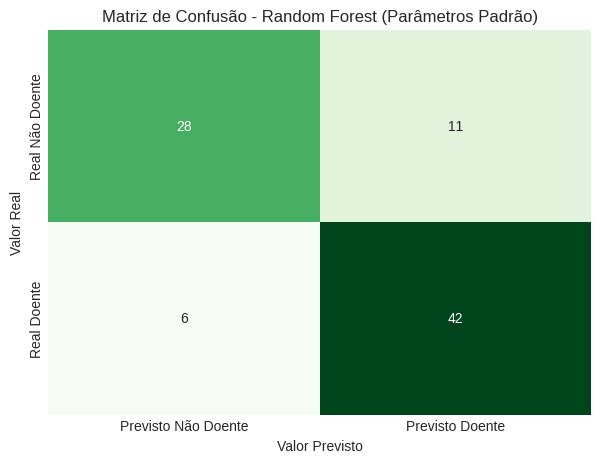


Métricas do Random Forest (Padrão) armazenadas.


In [ ]:
# Célula 4: Visualização da Matriz de Confusão
print("\nVisualizando a Matriz de Confusão para o Random Forest...")
plt.figure(figsize=(7, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Previsto Não Doente', 'Previsto Doente'],
            yticklabels=['Real Não Doente', 'Real Doente'])
plt.title('Matriz de Confusão - Random Forest (Parâmetros Padrão)')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

# Guardar métricas para possível comparação futura (opcional)
metrics_rf_initial = {
    'Modelo': 'Random Forest (Padrão)',
    'Acurácia': accuracy_rf,
    'Precisão': precision_rf,
    'Recall': recall_rf,
    'F1 Score': f1_rf,
    'Especificidade': specificity_rf,
    'AUC': auc_rf,
    'TP': tp_rf,
    'FP': fp_rf,
    'TN': tn_rf,
    'FN': fn_rf
}
print("\nMétricas do Random Forest (Padrão) armazenadas.")
# print(metrics_rf_initial)

#Deep Learning - Treino e avaliação

Indo além dos algoritmos de Machine Learning tradicionais tratados no artigo, exploramos a aplicação de Deep Learning. Nesta seção, construímos e treinamos um modelo de rede neural profunda, utilizando camadas densas (Fully Connected), e avaliamos seu desempenho no conjunto de teste, calculando as métricas relevantes.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Sequential([
    # Primeira camada oculta: 64 neurônios, ReLU
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),

    # Segunda camada oculta: 32 neurônios
    Dense(32, activation='relu'),
    Dropout(0.3),

    # Terceira camada oculta: 16 neurônios
    Dense(16, activation='relu'),

    # Camada de saída: 1 neurônio com sigmoid (problema binário)
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='AUC')]
)

# Parar o treinamento automaticamente assim que não melhorar a 'val_loss' por 10 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.20,      # 20% do conjunto de treino para validação interna
    epochs=100,                 # número máximo de épocas
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/100
6/6 - 3s - 466ms/step - AUC: 0.6360 - loss: 0.7086 - val_AUC: 0.6855 - val_loss: 0.7180
Epoch 2/100
6/6 - 0s - 22ms/step - AUC: 0.7197 - loss: 0.6612 - val_AUC: 0.7702 - val_loss: 0.6795
Epoch 3/100
6/6 - 0s - 22ms/step - AUC: 0.7092 - loss: 0.6569 - val_AUC: 0.8034 - val_loss: 0.6521
Epoch 4/100
6/6 - 0s - 23ms/step - AUC: 0.7697 - loss: 0.6392 - val_AUC: 0.8276 - val_loss: 0.6314
Epoch 5/100
6/6 - 0s - 23ms/step - AUC: 0.8031 - loss: 0.6028 - val_AUC: 0.8387 - val_loss: 0.6124
Epoch 6/100
6/6 - 0s - 24ms/step - AUC: 0.8032 - loss: 0.5945 - val_AUC: 0.8488 - val_loss: 0.5933
Epoch 7/100
6/6 - 0s - 21ms/step - AUC: 0.8371 - loss: 0.5799 - val_AUC: 0.8518 - val_loss: 0.5738
Epoch 8/100
6/6 - 0s - 21ms/step - AUC: 0.8352 - loss: 0.5572 - val_AUC: 0.8639 - val_loss: 0.5532
Epoch 9/100
6/6 - 0s - 24ms/step - AUC: 0.8310 - loss: 0.5518 - val_AUC: 0.8599 - val_loss: 0.5335
Epoch 10/100
6/6 - 0s - 20ms/step - AUC: 0.8286 - loss: 0.5261 - val_AUC: 0.8669 - val_loss: 0.5138
Epoch 11

In [ ]:
# 1) Previsão das probabilidades
y_pred_prob = model.predict(X_test_scaled).ravel()

# 2) Converter em classes (0 ou 1) usando limiar 0.5
y_pred = (y_pred_prob >= 0.5).astype(int)

# 3) Calcular métricas padrão
accuracy  = accuracy_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)                # sensibilidade
precision = precision_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
auc       = roc_auc_score(y_test, y_pred_prob)           # AUC ROC

# 4) Especificidade = TN / (TN + FP)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# 5) Exibir em um DataFrame pra visualização
import pandas as pd
results = {
    'Accuracy':        accuracy,
    'Recall (Sensibilidade)': recall,
    'Precision (Precisão)':  precision,
    'F1 Score':        f1,
    'AUC':             auc,
    'Specificity':     specificity
}
pd.DataFrame([results], index=['Deep Learning Model']).T


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


,Deep Learning Model
Accuracy,0.827586
Recall (Sensibilidade),0.968750
Precision (Precisão),0.775000
F1 Score,0.861111
AUC,0.867788
Specificity,0.653846


# Otimização de hiperparâmetros

Como fizemos com o modelo KNN, onde otimizamos seus hiperparâmetros para melhorar sua performance, aplicamos agora o mesmo conceito ao nosso modelo de Deep Learning. A otimização de hiperparâmetros é essencial para modelos neurais complexos. Utilizaremos o Keras Tuner para explorar diferentes configurações da rede e encontrar a combinação que produz os resultados mais promissores no conjunto de dados, visando criar um modelo mais potente e preciso.

In [ ]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
class HeartHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        # Escolhe número de unidades entre 32 e 128
        units = hp.Int('units', min_value=32, max_value=128, step=32)
        dropout_rate = hp.Float('dropout', 0.2, 0.5, step=0.1)

        model.add(Dense(units, activation='relu', input_shape=(X_train_scaled.shape[1],)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(int(units/2), activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
            ),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(name='AUC')]
        )
        return model

tuner = kt.RandomSearch(
    HeartHyperModel(),
    objective='val_AUC',
    max_trials=20,
    executions_per_trial=1,
    directory='heart_tuning',
    project_name='heart_auc'
)

tuner.search(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

# Melhor modelo:
best_model = tuner.get_best_models(num_models=1)[0]


Trial 20 Complete [00h 00m 06s]
val_AUC: 0.9112903475761414

Best val_AUC So Far: 0.9284274578094482
Total elapsed time: 00h 03m 41s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.evaluate(X_test_scaled, y_test, verbose=2)

2/2 - 1s - 296ms/step - AUC: 0.8924 - loss: 0.4127


[0.41266071796417236, 0.8924278616905212]

In [ ]:
# 1) Previsão das probabilidades no conjunto de teste
y_pred_prob = best_model.predict(X_test_scaled).ravel()

# 2) Converter as probabilidades em classes (0 ou 1) com limiar 0.5
y_pred = (y_pred_prob >= 0.5).astype(int)

# 3) Calcular métricas padrão
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

accuracy  = accuracy_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)       # sensibilidade
precision = precision_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
auc       = roc_auc_score(y_test, y_pred_prob)  # AUC ROC

# 4) Especificidade = TN / (TN + FP)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# 5) Montar DataFrame para visualização
import pandas as pd

results = {
    'Accuracy':               accuracy,
    'Recall (Sensibilidade)': recall,
    'Precision (Precisão)':   precision,
    'F1 Score':               f1,
    'AUC':                    auc,
    'Specificity':            specificity
}

pd.DataFrame([results], index=['Best Model']).T


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


,Best Model
Accuracy,0.844828
Recall (Sensibilidade),0.937500
Precision (Precisão),0.810811
F1 Score,0.869565
AUC,0.893029
Specificity,0.730769


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


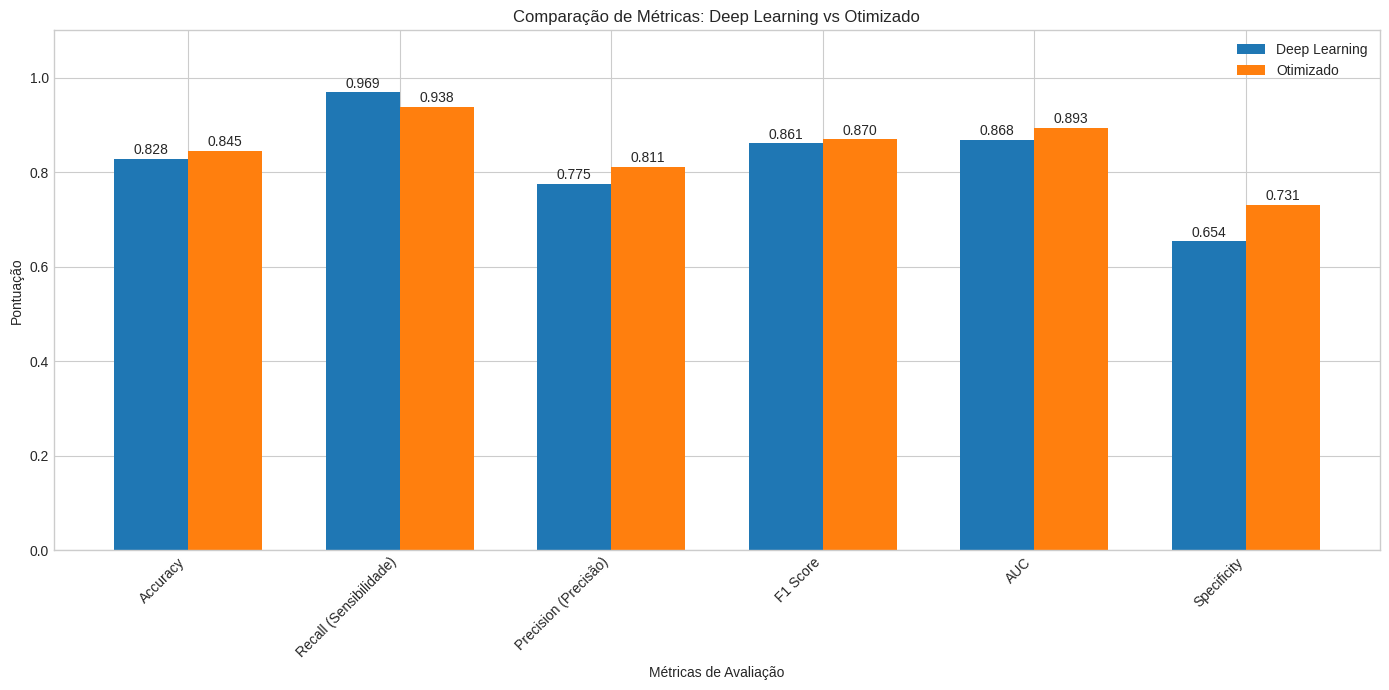


Resumo da Comparação:
                  Métrica  Deep Learning  Otimizado
0                Accuracy       0.827586   0.844828
1  Recall (Sensibilidade)       0.968750   0.937500
2    Precision (Precisão)       0.775000   0.810811
3                F1 Score       0.861111   0.869565
4                     AUC       0.867788   0.893029
5             Specificity       0.653846   0.730769


In [ ]:
y_pred_prob_dl = model.predict(X_test_scaled).ravel()
y_pred_dl = (y_pred_prob_dl >= 0.5).astype(int)

accuracy_dl    = accuracy_score(y_test, y_pred_dl)
recall_dl      = recall_score(y_test, y_pred_dl)
precision_dl   = precision_score(y_test, y_pred_dl)
f1_dl          = f1_score(y_test, y_pred_dl)
auc_dl         = roc_auc_score(y_test, y_pred_prob_dl)

tn_dl, fp_dl, fn_dl, tp_dl = confusion_matrix(y_test, y_pred_dl).ravel()
specificity_dl = tn_dl / (tn_dl + fp_dl)

metrics_dl = {
    "Accuracy":                 accuracy_dl,
    "Recall (Sensibilidade)":   recall_dl,
    "Precision (Precisão)":     precision_dl,
    "F1 Score":                 f1_dl,
    "AUC":                      auc_dl,
    "Specificity":              specificity_dl
}

y_pred_prob_opt = best_model.predict(X_test_scaled).ravel()
y_pred_opt      = (y_pred_prob_opt >= 0.5).astype(int)

accuracy_opt    = accuracy_score(y_test, y_pred_opt)
recall_opt      = recall_score(y_test, y_pred_opt)
precision_opt   = precision_score(y_test, y_pred_opt)
f1_opt          = f1_score(y_test, y_pred_opt)
auc_opt         = roc_auc_score(y_test, y_pred_prob_opt)

tn_opt, fp_opt, fn_opt, tp_opt = confusion_matrix(y_test, y_pred_opt).ravel()
specificity_opt = tn_opt / (tn_opt + fp_opt)

metrics_opt = {
    "Accuracy":                 accuracy_opt,
    "Recall (Sensibilidade)":   recall_opt,
    "Precision (Precisão)":     precision_opt,
    "F1 Score":                 f1_opt,
    "AUC":                      auc_opt,
    "Specificity":              specificity_opt
}

metrics_names = list(metrics_dl.keys())
dl_scores     = [metrics_dl[m] for m in metrics_names]
opt_scores    = [metrics_opt[m] for m in metrics_names]

comparison_df = pd.DataFrame({
    "Métrica":        metrics_names,
    "Deep Learning":  dl_scores,
    "Otimizado":      opt_scores
})

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 7))

x     = list(range(len(metrics_names)))
width = 0.35

ax.bar([p - width/2 for p in x], dl_scores, width, label="Deep Learning")
ax.bar([p + width/2 for p in x], opt_scores, width, label="Otimizado")

ax.set_xticks(x)
ax.set_xticklabels(metrics_names, rotation=45, ha="right")
ax.set_ylabel("Pontuação")
ax.set_xlabel("Métricas de Avaliação")
ax.set_title("Comparação de Métricas: Deep Learning vs Otimizado")

for i in x:
    ax.text(i - width/2, dl_scores[i] + 0.01,    f"{dl_scores[i]:.3f}", ha="center")
    ax.text(i + width/2, opt_scores[i] + 0.01,   f"{opt_scores[i]:.3f}", ha="center")

ax.set_ylim(0, 1.1)
ax.legend()
plt.tight_layout()
plt.show()

print("\nResumo da Comparação:")
print(comparison_df)


De forma geral, o modelo otimizado apresenta desempenho um pouco superior ao método de Deep Learning: a acurácia subiu de 82,76% para 84,48%, a precisão aumentou de 77,50% para 81,08% e o AUC passou de 0,8678 para 0,8930. Embora a sensibilidade tenha caído um pouco (de 96,88% para 93,75%), houve melhora no F1 (de 0,8611 para 0,8696) e na especificidade (de 65,38% para 73,08%), nos mostrando que o modelo otimizado equilibrou melhor a detecção de positivos e negativos em comparação ao Deep Learning.


#Regressão logística - Treino e avaliação

Seguindo o exemplo dado pelo artigo, agora usaremos regressão logística de forma comparativa com os outros algoritmos utilizados. É um algoritmo linear e relativamente simples, o que facilita a compreensão de como as features influenciam o resultado.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Crie uma instância do modelo
# Use o parâmetro random_state para reprodutibilidade
# O parâmetro 'solver' pode ser 'liblinear', 'lbfgs', etc. 'liblinear' é bom para datasets menores
log_reg = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')

# Treine o modelo nos dados de treinamento escalonados
print("\nTreinando o modelo de Regressão Logística...")
log_reg.fit(X_train_scaled, y_train)
print("Modelo de Regressão Logística treinado.")


Treinando o modelo de Regressão Logística...
Modelo de Regressão Logística treinado.



Avaliando o modelo de Regressão Logística...

Métricas do Modelo de Regressão Logística:
  Acurácia: 0.7931
  Precisão: 0.7632
  Recall (Sensibilidade): 0.9062
  F1 Score: 0.8286
  Especificidade: 0.6538
  AUC: 0.8678

Matriz de Confusão (Regressão Logística):
  Verdadeiros Positivos (TP): 29
  Falsos Positivos (FP): 9
  Verdadeiros Negativos (TN): 17
  Falsos Negativos (FN): 3


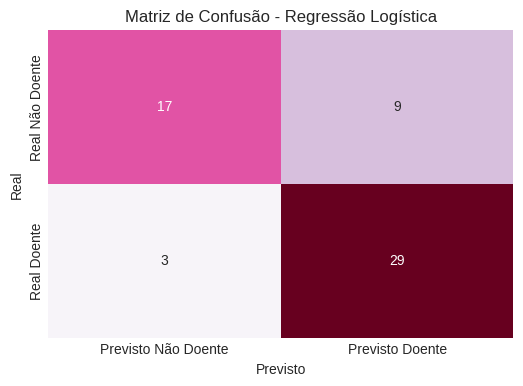

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print("\nAvaliando o modelo de Regressão Logística...")
# Fazer previsões no conjunto de teste escalonado
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1] # Probabilidades para AUC

# Calcular métricas de avaliação
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)
auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)

# Calcular Matriz de Confusão e Especificidade
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
tn_log_reg, fp_log_reg, fn_log_reg, tp_log_reg = cm_log_reg.ravel()
specificity_log_reg = tn_log_reg / (tn_log_reg + fp_log_reg) if (tn_log_reg + fp_log_reg) > 0 else 0


print("\nMétricas do Modelo de Regressão Logística:")
print(f"  Acurácia: {accuracy_log_reg:.4f}")
print(f"  Precisão: {precision_log_reg:.4f}")
print(f"  Recall (Sensibilidade): {recall_log_reg:.4f}")
print(f"  F1 Score: {f1_log_reg:.4f}")
print(f"  Especificidade: {specificity_log_reg:.4f}")
print(f"  AUC: {auc_log_reg:.4f}")

print("\nMatriz de Confusão (Regressão Logística):")
print(f"  Verdadeiros Positivos (TP): {tp_log_reg}")
print(f"  Falsos Positivos (FP): {fp_log_reg}")
print(f"  Verdadeiros Negativos (TN): {tn_log_reg}")
print(f"  Falsos Negativos (FN): {fn_log_reg}")

# Plotar Matriz de Confusão (Opcional, mas recomendado)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='PuRd', cbar=False,
xticklabels=['Previsto Não Doente', 'Previsto Doente'],
yticklabels=['Real Não Doente', 'Real Doente'])
plt.title('Matriz de Confusão - Regressão Logística')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

# Armazenar métricas para comparação
metrics_log_reg = {
  'Modelo': 'Regressão Logística',
  'Acurácia': accuracy_log_reg,
  'Precisão': precision_log_reg,
  'Recall': recall_log_reg,
  'F1 Score': f1_log_reg,
  'Especificidade': specificity_log_reg,
  'AUC': auc_log_reg,
  'TP': tp_log_reg,
  'FP': fp_log_reg,
  'TN': tn_log_reg,
  'FN': fn_log_reg
}

#SVC (Support Vector Classifier) - Treino e avaliação

Seguindo ao artigo, vamos em frente para outro algoritmo de ML, o SVC (Support Vector Classifier). ideia central por trás do SVC é encontrar o "melhor" hiperplano (uma linha em 2D, um plano em 3D, e assim por diante em dimensões maiores) que separa diferentes classes de dados no espaço de features.


Treinando o modelo SVM...
Modelo SVM treinado.

Avaliando o modelo SVM...

Métricas do Modelo SVM:
  Acurácia: 0.7931
  Precisão: 0.7632
  Recall (Sensibilidade): 0.9062
  F1 Score: 0.8286
  Especificidade: 0.6538
  AUC: 0.8341

Matriz de Confusão (SVM):
  Verdadeiros Positivos (TP): 29
  Falsos Positivos (FP): 9
  Verdadeiros Negativos (TN): 17
  Falsos Negativos (FN): 3


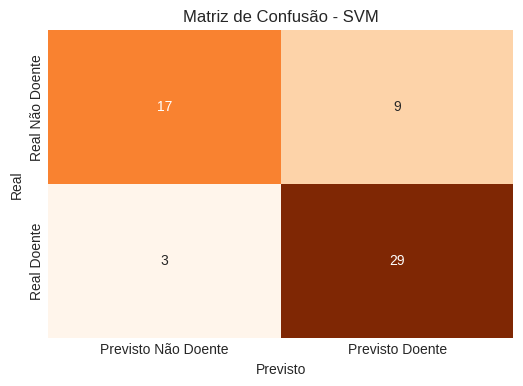

In [ ]:
# Célula de Código: Implementação e Treinamento do SVM

print("\nTreinando o modelo SVM...")
from sklearn.svm import SVC

# Instanciar o Support Vector Classifier
# Usamos probability=True para poder calcular o AUC (requer predict_proba)
# O kernel 'rbf' é um kernel comum e poderoso. 'gamma' e 'C' são hiperparâmetros importantes.
# Usar random_state para reprodutibilidade
svm_model = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)

# Treinar o modelo usando o conjunto de treinamento escalonado
svm_model.fit(X_train_scaled, y_train)
print("Modelo SVM treinado.")

# Célula de Código: Avaliação do Modelo SVM

print("\nAvaliando o modelo SVM...")
# Fazer previsões no conjunto de teste escalonado
y_pred_svm = svm_model.predict(X_test_scaled)

# Obter probabilidades para o cálculo do AUC
# svm_model.predict_proba() é necessário quando probability=True
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1] # Probabilidades para a classe positiva (1)

# Calcular métricas de avaliação
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

# Calcular Matriz de Confusão e Especificidade
cm_svm = confusion_matrix(y_test, y_pred_svm)
tn_svm, fp_svm, fn_svm, tp_svm = cm_svm.ravel()
specificity_svm = tn_svm / (tn_svm + fp_svm) if (tn_svm + fp_svm) > 0 else 0

print("\nMétricas do Modelo SVM:")
print(f"  Acurácia: {accuracy_svm:.4f}")
print(f"  Precisão: {precision_svm:.4f}")
print(f"  Recall (Sensibilidade): {recall_svm:.4f}")
print(f"  F1 Score: {f1_svm:.4f}")
print(f"  Especificidade: {specificity_svm:.4f}")
print(f"  AUC: {auc_svm:.4f}")

print("\nMatriz de Confusão (SVM):")
print(f"  Verdadeiros Positivos (TP): {tp_svm}")
print(f"  Falsos Positivos (FP): {fp_svm}")
print(f"  Verdadeiros Negativos (TN): {tn_svm}")
print(f"  Falsos Negativos (FN): {fn_svm}")

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Previsto Não Doente', 'Previsto Doente'],
            yticklabels=['Real Não Doente', 'Real Doente'])
plt.title('Matriz de Confusão - SVM')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

metrics_svm = {
    'Modelo': 'SVM',
    'Acurácia': accuracy_svm,
    'Precisão': precision_svm,
    'Recall': recall_svm,
    'F1 Score': f1_svm,
    'Especificidade': specificity_svm,
    'AUC': auc_svm,
    'TP': tp_svm,
    'FP': fp_svm,
    'TN': tn_svm,
    'FN': fn_svm
}

#GNB - Gaussian Naive Bayes

Para nosso passo, nos aprofundaremos em mais outro modelo de machine learning, o GNB. O Gaussian Naive Bayes é um classificador probabilístico simples baseado no teorema de Bayes com a suposição de independência forte entre as features. "Gaussian" indica que ele assume que a probabilidade das features numéricas segue uma distribuição Gaussiana (normal).


Treinando o modelo Gaussian Naïve Bayes...
Modelo Gaussian Naïve Bayes treinado.

Avaliando o modelo Gaussian Naïve Bayes...

Métricas do Modelo Gaussian Naïve Bayes:
  Acurácia: 0.7931
  Precisão: 0.7941
  Recall (Sensibilidade): 0.8438
  F1 Score: 0.8182
  Especificidade: 0.7308
  AUC: 0.8786

Matriz de Confusão (Gaussian Naïve Bayes):
  Verdadeiros Positivos (TP): 27
  Falsos Positivos (FP): 7
  Verdadeiros Negativos (TN): 19
  Falsos Negativos (FN): 5


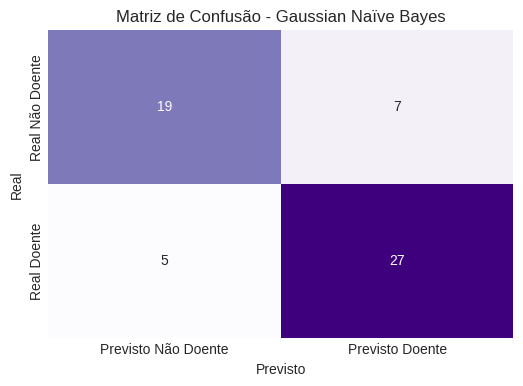

In [ ]:
# Célula de Código: Implementação e Treinamento do Gaussian Naïve Bayes

print("\nTreinando o modelo Gaussian Naïve Bayes...")
from sklearn.naive_bayes import GaussianNB

# Instanciar o GaussianNB
gnb_model = GaussianNB()

# Treinar o modelo usando o conjunto de treinamento (escalonado)
# Embora GNB não seja tão sensível à escala quanto alguns outros modelos,
# usar os dados escalonados mantém a consistência com o pipeline anterior.
gnb_model.fit(X_train_scaled, y_train)
print("Modelo Gaussian Naïve Bayes treinado.")

# Célula de Código: Avaliação do Modelo Gaussian Naïve Bayes

print("\nAvaliando o modelo Gaussian Naïve Bayes...")
# Fazer previsões no conjunto de teste escalonado
y_pred_gnb = gnb_model.predict(X_test_scaled)

# Obter probabilidades para o cálculo do AUC
y_pred_proba_gnb = gnb_model.predict_proba(X_test_scaled)[:, 1] # Probabilidades para a classe positiva (1)

# Calcular métricas de avaliação
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
precision_gnb = precision_score(y_test, y_pred_gnb)
recall_gnb = recall_score(y_test, y_pred_gnb)
f1_gnb = f1_score(y_test, y_pred_gnb)
auc_gnb = roc_auc_score(y_test, y_pred_proba_gnb)

# Calcular Matriz de Confusão e Especificidade
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
tn_gnb, fp_gnb, fn_gnb, tp_gnb = cm_gnb.ravel()
specificity_gnb = tn_gnb / (tn_gnb + fp_gnb) if (tn_gnb + fp_gnb) > 0 else 0

print("\nMétricas do Modelo Gaussian Naïve Bayes:")
print(f"  Acurácia: {accuracy_gnb:.4f}")
print(f"  Precisão: {precision_gnb:.4f}")
print(f"  Recall (Sensibilidade): {recall_gnb:.4f}")
print(f"  F1 Score: {f1_gnb:.4f}")
print(f"  Especificidade: {specificity_gnb:.4f}")
print(f"  AUC: {auc_gnb:.4f}")

print("\nMatriz de Confusão (Gaussian Naïve Bayes):")
print(f"  Verdadeiros Positivos (TP): {tp_gnb}")
print(f"  Falsos Positivos (FP): {fp_gnb}")
print(f"  Verdadeiros Negativos (TN): {tn_gnb}")
print(f"  Falsos Negativos (FN): {fn_gnb}")

# Plotar Matriz de Confusão
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Previsto Não Doente', 'Previsto Doente'],
            yticklabels=['Real Não Doente', 'Real Doente'])
plt.title('Matriz de Confusão - Gaussian Naïve Bayes')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

# Armazenar métricas para comparação
metrics_gnb = {
    'Modelo': 'Gaussian Naïve Bayes',
    'Acurácia': accuracy_gnb,
    'Precisão': precision_gnb,
    'Recall': recall_gnb,
    'F1 Score': f1_gnb,
    'Especificidade': specificity_gnb,
    'AUC': auc_gnb,
    'TP': tp_gnb,
    'FP': fp_gnb,
    'TN': tn_gnb,
    'FN': fn_gnb
}

#Decision tree (DT) - Treino e avaliação

O próximo algoritmo abordado, como no artigo, será o DT (Decision Tree), um modelo não paramétrico que aprende a tomar decisões sequenciais baseadas nos valores das features. Ela divide os dados em subconjuntos com base em regras simples e cria uma estrutura em forma de árvore onde cada nó interno representa um teste em uma feature, cada ramo representa o resultado do teste, e cada nó folha representa a decisão final (a classe prevista).


Treinando o modelo Decision Tree...
Modelo Decision Tree treinado.

Avaliando o modelo Decision Tree...

Métricas do Modelo Decision Tree:
  Acurácia: 0.6552
  Precisão: 0.6875
  Recall (Sensibilidade): 0.6875
  F1 Score: 0.6875
  Especificidade: 0.6154
  AUC: 0.6514

Matriz de Confusão (Decision Tree):
  Verdadeiros Positivos (TP): 22
  Falsos Positivos (FP): 10
  Verdadeiros Negativos (TN): 16
  Falsos Negativos (FN): 10


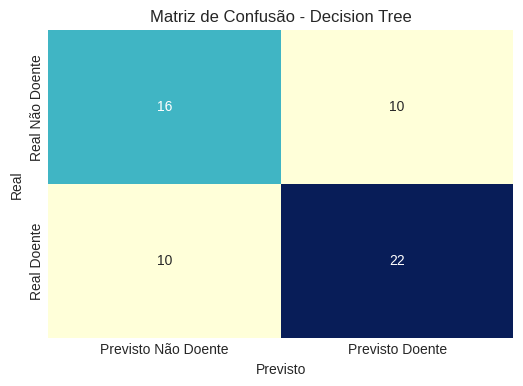

In [ ]:
# Célula de Código: Implementação e Treinamento da Decision Tree

print("\nTreinando o modelo Decision Tree...")
from sklearn.tree import DecisionTreeClassifier

# Instanciar o DecisionTreeClassifier
# Usar random_state para reprodutibilidade
# Você pode ajustar hiperparâmetros como max_depth, min_samples_split, etc.
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Treinar o modelo usando o conjunto de treinamento (escalonado ou não escalonado, ambos funcionam para DT)
# Vamos continuar usando o escalonado para consistência, mas o original X_train também é válido.
dt_model.fit(X_train_scaled, y_train)
print("Modelo Decision Tree treinado.")

# Célula de Código: Avaliação do Modelo Decision Tree

print("\nAvaliando o modelo Decision Tree...")
# Fazer previsões no conjunto de teste escalonado
y_pred_dt = dt_model.predict(X_test_scaled)

# Obter probabilidades para o cálculo do AUC
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1] # Probabilidades para a classe positiva (1)

# Calcular métricas de avaliação
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

# Calcular Matriz de Confusão e Especificidade
cm_dt = confusion_matrix(y_test, y_pred_dt)
tn_dt, fp_dt, fn_dt, tp_dt = cm_dt.ravel()
specificity_dt = tn_dt / (tn_dt + fp_dt) if (tn_dt + fp_dt) > 0 else 0

print("\nMétricas do Modelo Decision Tree:")
print(f"  Acurácia: {accuracy_dt:.4f}")
print(f"  Precisão: {precision_dt:.4f}")
print(f"  Recall (Sensibilidade): {recall_dt:.4f}")
print(f"  F1 Score: {f1_dt:.4f}")
print(f"  Especificidade: {specificity_dt:.4f}")
print(f"  AUC: {auc_dt:.4f}")

print("\nMatriz de Confusão (Decision Tree):")
print(f"  Verdadeiros Positivos (TP): {tp_dt}")
print(f"  Falsos Positivos (FP): {fp_dt}")
print(f"  Verdadeiros Negativos (TN): {tn_dt}")
print(f"  Falsos Negativos (FN): {fn_dt}")

# Plotar Matriz de Confusão
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['Previsto Não Doente', 'Previsto Doente'],
            yticklabels=['Real Não Doente', 'Real Doente'])
plt.title('Matriz de Confusão - Decision Tree')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

# Armazenar métricas para comparação
metrics_dt = {
    'Modelo': 'Decision Tree',
    'Acurácia': accuracy_dt,
    'Precisão': precision_dt,
    'Recall': recall_dt,
    'F1 Score': f1_dt,
    'Especificidade': specificity_dt,
    'AUC': auc_dt,
    'TP': tp_dt,
    'FP': fp_dt,
    'TN': tn_dt,
    'FN': fn_dt
}

#Conclusão e resultados

##Modelos clássicos de machine learning


De modo geral, os resultados indicam que algoritmos baseados em ensemble (Random Forest) e modelos probabilísticos (Gaussian Naïve Bayes) foram particularmente eficazes para o prognóstico de doenças cardiovasculares isquêmicas neste dataset. O Random Forest apresentou a maior acurácia e um bom equilíbrio entre recall e especificidade, enquanto o Gaussian Naïve Bayes alcançou o maior valor de AUC, sugerindo uma maior capacidade de distinguir casos positivos e negativos.

A Regressão Logística e o SVM também demonstraram resultados consistentes, especialmente com valores elevados de recall (0,9062), destacando sua aptidão para reduzir a ocorrência de falsos negativos — fator crítico em aplicações médicas, onde a falha em identificar um paciente doente pode ter consequências graves.

Por outro lado, o modelo Decision Tree, apesar de sua simplicidade e interpretabilidade, mostrou-se menos eficaz, provavelmente devido à tendência ao overfitting e às limitações no poder discriminatório em dados tabulares com alta dimensionalidade.

A descoberta de um número significativo de duplicatas no conjunto de dados original (723 observações duplicadas) pode ter impactado a estabilidade de alguns modelos, mas os resultados gerais reforçam a utilidade dos métodos clássicos de ML na predição de doenças cardiovasculares isquêmicas — mesmo em cenários com dados inconsistentes.

## Deep Learning

O modelo de Deep Learning (DL) demonstrou desempenho superior em várias métricas quando comparado aos modelos clássicos de aprendizado de máquina. Com uma acurácia de 82,76%, o DL se posicionou entre os modelos mais precisos, superando o KNN (78,16%), o Gaussian Naïve Bayes (79,31%) e equiparando-se à Regressão Logística e SVM (79,31%). No entanto, seu maior destaque foi o recall (sensibilidade) de 96,88%, o mais alto entre todos os modelos testados, indicando uma capacidade excepcional de identificar corretamente pacientes com doenças cardíacas isquêmicas, minimizando falsos negativos – um aspecto crítico em aplicações médicas.

Além disso, o DL apresentou o melhor F1-Score (86,11%), superando modelos como SVM (82,86%) e GNB (81,82%), o que reflete um equilíbrio mais eficiente entre precisão e recall. O AUC (86,78%) também foi elevado, ficando atrás apenas do Gaussian Naïve Bayes (87,86%), confirmando sua robustez na discriminação entre classes.

Por outro lado, o modelo de Deep Learning apresentou uma especificidade mais baixa (65,38%) em comparação a outros algoritmos, como Random Forest (71,79%) e GNB (73,08%), indicando uma maior tendência a falsos positivos. Essa característica sugere que, embora o DL seja altamente eficaz na detecção de casos positivos, pode exigir uma etapa adicional de confirmação para reduzir diagnósticos incorretos em pacientes saudáveis.

Em resumo, o Deep Learning destacou-se como a melhor opção para triagem inicial, especialmente em cenários onde a prioridade é evitar falsos negativos. No entanto, sua menor especificidade indica que uma abordagem híbrida, combinando-o com modelos de alta especificidade (como Random Forest ou GNB), poderia otimizar ainda mais o diagnóstico. Esses resultados reforçam o potencial do DL como ferramenta auxiliar no diagnóstico precoce de doenças cardíacas isquêmicas, complementando métodos tradicionais e melhorando a eficácia clínica.